In [1]:
import os
import sys
sys.path.append('../')
sys.path.append('../datasets')
sys.path.append('../models')
import torch
import torchvision
import torch.backends.cudnn as cudnn
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from importlib import reload
from datasets.three_dim_shapes import ThreeDimShapesDataset
from datasets.small_norb import SmallNORBDataset
from datasets.seq_mnist import SequentialMNIST
import models.seqae as seqae
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from datasets import so3_data as so3d
from einops import rearrange
from sklearn.metrics import r2_score
import pdb
import copy

import csv
import ast
from source import yaml_utils as yu


from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    gpu_index = -1

    
    
from utils import yaml_utils as yu
import yaml
rootpath = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/'
result_dir = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result'





In [13]:
targdir = '20220701_so3_various_dat_three_0'
exp_result = os.path.join(result_dir, targdir)


def iter_list(log_dir):
    dirlist = os.listdir(log_dir)
    iterlist = []
    for mydir in dirlist:
        if 'iter' in mydir:
            iterlist.append(int(mydir.split('_')[-1]))
    return np.array(iterlist)
    
    
def load_model(model, log_dir, iters, latest=False):
    print('snapshot_model_iter_{}'.format(iters))
    if latest == True:
        iters = np.max(iter_list(log_dir))
    model.load_state_dict(torch.load(os.path.join(log_dir, 'snapshot_model_iter_{}'.format(iters))))



def load_config(targdir_path):
    targ_config_path = os.path.join(targdir_path, 'config.yml')
    with open(targ_config_path, 'r') as f:
        config = yaml.safe_load(f)
    return config
    
    
def filter_names(query, mydict):
    filtered = {} 
    for key in mydict.keys():
        if query in key:
            filtered[key] = mydict[key]
    return filtered


def filter_list(query, mylist):
    filtered = [] 
    for key in mylist:
        if query in key:
            filtered.append(key)
    return filtered
    
    
os.listdir(exp_result)




['data_filenameso3dat_sphere_MLPpt_nameSeqAELSTSQ_LinearNet',
 'data_filenameso3dat_sphere_Linearpt_nameSeqAELSTSQ_LinearNet',
 'data_filenameso3dat_sphere_iResNetpt_nameSeqAELSTSQ_so3Net',
 'data_filenameso3dat_sphere_Linearpt_nameSeqAELSTSQ_so3Net',
 'data_filenameso3dat_sphere_iResNetpt_nameSeqAELSTSQ_LinearNet',
 'data_filenameso3dat_sphere_MLPpt_nameSeqAELSTSQ_so3Net']

In [90]:
results = {} 
inferred_Ms = {} 
tp = 3
n_cond = 5

targlist = [] 

query = 'dat_sphere_Linearpt'
targlist = filter_list(query, os.listdir(exp_result))


for targdir in targlist:
    
    Mlist = [] 
    targdir_path = os.path.join(exp_result, targdir)
    config = load_config(targdir_path)
    
    dataconfig = config['train_data']
    dataconfig['args']['T'] = tp + n_cond
    
    data = yu.load_component(dataconfig)
    train_loader = DataLoader(data, 
                              batch_size=config['batchsize'],
                              shuffle=True,
                              num_workers=config['num_workers'])
    model = yu.load_component(config['model'])
    iterlist = iter_list(targdir_path)
    
    if len(iterlist) == 0:
        print(f"""There is no model trained for {targdir_path}""")
    else:
        maxiter = np.max(iter_list(targdir_path))
        load_model(model, targdir_path, maxiter)
        model = model.eval().to(device)

        # Initialize lazy modules
        images = iter(train_loader).next()
        images = images.to(device)
        model(images[:, :2])

        with torch.no_grad():
            scores = [] 
            for images in tqdm(train_loader):
                images = images.to(device)
                images_cond = images[:, :n_cond]
                images_target = images[:, n_cond:n_cond+tp]
                M = model.get_M(images_cond) #n a a
                H = model.encode(images_cond[:, -1:])[:, 0] # n s a

                xs = []
                for r in range(tp):
                    H = H @ M 
                    x_next_t = model.decode(H[:, None])
                    xs.append(x_next_t)

                x_next = torch.cat(xs, axis=1)
                r2_losses = [] 
                for k in range(tp):
                    r2_loss_t = r2_score(images_target[:,k].to('cpu').numpy(), x_next[:,k].to('cpu').numpy()) 
                    r2_losses.append(r2_loss_t)
                scores.append(torch.tensor(r2_losses))
                Mlist.append(M)
        
                
        Mlist = torch.cat(Mlist)       
        scores = torch.stack(scores)
        av_score = torch.mean(scores, axis=0)
        av_var = torch.var(scores, axis=0)
        results[targdir] = [av_score, av_var]
        inferred_Ms[targdir] = Mlist 


    

/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


snapshot_model_iter_1000000


100%|██████████| 313/313 [00:01<00:00, 170.83it/s]
/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


snapshot_model_iter_1000000


100%|██████████| 313/313 [00:02<00:00, 146.41it/s]


In [100]:
result_list = list(results.keys())
print(result_list)

['data_filenameso3dat_sphere_Linearpt_nameSeqAELSTSQ_LinearNet', 'data_filenameso3dat_sphere_Linearpt_nameSeqAELSTSQ_so3Net']


In [101]:
print(inferred_Ms[result_list[0]].shape)
S = torch.abs(inferred_Ms[result_list[0]])
STS = torch.matmul(S.transpose(-2, -1), S)
print(STS.shape)


torch.Size([10000, 6, 6])
torch.Size([10000, 6, 6])


In [102]:
from utils import optimize_bd_cob as obc
from importlib import reload
reload(obc)

<module 'utils.optimize_bd_cob' from '../utils/optimize_bd_cob.py'>

In [103]:
Pmat = obc.optimize_bd_cob(STS)


ep:9 loss:2.8329090282440186
ep:19 loss:2.831703650665283
ep:29 loss:2.830491424179077
ep:39 loss:2.8301649604797365
ep:49 loss:2.8292694206237794


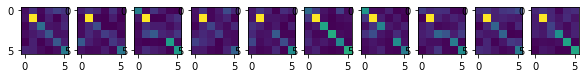

In [124]:
PSP = torch.abs(Pmat(S).detach().to('cpu'))
toshow = 10
plt.figure(figsize= (toshow, 1))
for k in range(toshow):
    plt.subplot(1, toshow, k+1)
    plt.imshow(PSP[k])

In [125]:
PSP[10]

tensor([[0.1476, 0.1563, 0.1401, 0.0134, 0.1081, 0.3852],
        [0.1150, 2.1403, 0.1709, 0.0860, 0.2542, 0.1297],
        [0.0651, 0.2073, 0.2333, 0.1352, 0.2157, 0.0051],
        [0.2411, 0.4714, 0.1226, 0.2995, 0.0466, 0.1300],
        [0.0049, 0.0680, 0.2001, 0.1336, 0.8037, 0.0724],
        [0.0639, 0.0901, 0.1145, 0.1082, 0.0202, 0.8160]])

In [126]:
ls /mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result

20220511_so3_exp_0/
20220611_so3/
20220611_so3_so3run/
20220611_so3_so3run_rcst/
20220611_so3_so3run_rcst_iter/
20220615_Mstar_comm/
20220615_NeuralMstar/
20220615_NeuralMstar_neuralM/
20220615_NeuralMstar_neuralM_vanilla/
20220615_default_run_mnist/
20220617_NeuralMstar_bg_neuralM_comm/
20220617_NeuralMstar_bg_neuralM_vanilla/
20220617_default_run_mnist_bg/
20220621_NeuralMstar_bg_neuralM_comm/
20220621_NeuralMstar_bg_neuralM_vanilla/
20220621_default_run_mnist_bg/
20220621_so3_rcst_so3run/
20220621_so3_rcst_so3run_rcst/
20220624_Mstar_longer_tp_neuralM_comm/
20220624_Mstar_longer_tp_neuralM_vanilla/
20220624_NeuralMstar_comm_bg_neuralM_comm/
20220624_NeuralMstar_comm_bg_neuralM_vanilla/
20220628_NeuralMstar_comm_0/
20220628_longer_tp_0/
20220628_pfkube_try_0/
20220628_so3_idnet_0/
20220628_so3_linear_net_0/
20220628_so3_various_dat_0/
20220629_so3_various_dat_0/
20220630_NeuralMstar_comm_0/
20220630_longer_tp_0/
20220630_so3_various_dat_0/
20220701_so3_various_dat_four_0/
20220701_so

In [132]:
dataconfig 

{'args': {'T': 8, 'data_filename': 'so3dat_sphere_Linear.pt', 'train': True},
 'fn': './datasets/so3_data.py',
 'name': 'SO3rotationSequence'}

In [131]:
ls ../datasets/

__init__.py   seq_mnist.py   so3_data.py
__pycache__/  small_norb.py  three_dim_shapes.py


In [133]:
ls  /mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/

MNIST/  so3/
